# 10. Spatiocyteを用いた一分子粒度のシミュレーション

これまでのチュートリアルで E-Cell4 の空間表現の例を示しました。
次に、「一分子粒度」と呼ばれる、より詳細な空間表現を用いてモデルをシミュレートしてみましょう。


In [1]:
%matplotlib inline
from ecell4 import *
from ecell4_base import *
from ecell4_base.core import *

## 10.1. 格子法のSpatiocyte

空間的なGillespie法では、`Space` をより小さな `Space` に分割し、サブボリューム内の分子を拡散させます。
しかし、我々は各サブボリュームにおける分子を分子の数として扱い、分子の位置は定められていませんでした。

言い換えると、空間的Gillespie法の空間分解能はサブボリューム $l$ の面に等しくなります。
この分解能を改善するには、$l$のサイズを小さくする必要があります。
しかし、この方法では、$l$は分子の直径$R$の(少なくとも)10倍より大きくなければなりません。

どうすれば分子のサイズに対して空間分解能を向上させることができるでしょうか？
答えは、1分子粒度のシミュレーションになります。
この方法は、分子の数ではなく各分子の空間的な反応拡散を用いて分子をシミュレートします。

E-Cell4には複数の一分子粒度の手法があり、ここでは格子法のSpatiocyteについて説明します。
Spatiocyteは、各分子を剛体球として扱い、分子を六方最密格子に拡散させます。

Spatiocyteは、各分子のIDとその分子の一分子粒度での位置を保持しています。
より高い空間分解能のために、SpatiocyteはSpatical Gillespieより100倍小さい時間ステップを持っています。
なぜならその拡散の時間スケールが距離の2乗とともに増加するためです。

それではSpatiocyteを試してみましょう。


In [2]:
with species_attributes():
    A | B | C | {'D': 1}

with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

w = spatiocyte.World(ones(), 0.005)  # The second argument is 'voxel_radius'.
w.bind_to(m)
w.add_molecules(Species('C'), 60)

sim = spatiocyte.Simulator(w)
obs = FixedIntervalNumberObserver(0.1, ('A', 'B', 'C'))
sim.run(10, obs)

`SpatiocyteWorld`の第二引数には明確な違いがあります。 これを`voxel radius`といいます。
Spatiocyteでは、空間を分子の大きさで割って分子の位置を定義し、この空間の最小単位を `Voxel`と呼んでいます。

ほとんどの場合、分子のサイズは`voxel radius`に適しているでしょう。
この例では、一辺が $\mathrm{\mu m}$ の空間内の分子の半径として5 $\mathrm{nm}$ を設定しました。
シミュレーションに時間がかかりますが、結果はODEまたはGillespieと同じです。


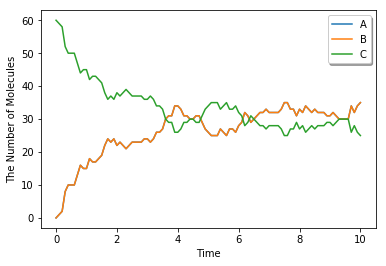

In [3]:
show(obs)

## 10.2. 一分子の拡散運動

次にその分解能を確認するために一分子粒度の拡散をシミュレートしてみましょう。


In [4]:
with species_attributes():
    A | {'D': 1}

m = get_model()

w = spatiocyte.World(ones(), 0.005)
w.bind_to(m)

pid = w.new_particle(Species('A'), 0.5 * ones())

`new_particle`メソッドは`spatiocyte.World`の座標に粒子を置こうとします。
また`new_particle`メソッドは粒子のParticleID(`pid`)を返します。
`new_particle`が粒子を置くことに失敗した場合、`pid`は`None`になります。

粒子がすでに座標に配置されている場合は、粒子を置くことはできず、失敗します。

`Particle`は粒子の位置、`species type`、半径、拡散係数を含んでいます。
`Particle`の情報はそのID `pid` を使って調べることが可能です。

それではまず `Particle`をチェックしてみましょう。


In [5]:
pid, p = w.get_particle(pid)
print(p.species().serial())  # must print: A
print(p.radius(), p.D())  # must print: (0.005, 1.0)
print(tuple(p.position()))  # must print: (0.49806291436591293, 0.49652123150307814, 0.5)

A
0.005 1.0
(0.49806291436591293, 0.49652123150307814, 0.5)


`get_particle`メソッドは、粒子のIDを受け取り、IDと粒子を返します（もちろんそのIDは与えられるIDと同じです）。
また`position()`メソッドで粒子の座標を `Real3`として調べることができます。
座標を直接読み取ることは難しいですが、ここではタプルに変換してからプリントしました。

上記の結果からわかるように、タプルのコーディネイトは `Real3`として与えられた元の位置とわずかに異なります。
これは、Spatiocyteが分子を格子上にのみ置くことができるからです。
`SpatiocyteWorld`は、分子を引数Real3の最も近い格子の中心に置きます。

`viz.plot_world`メソッドを使って分子の座標を可視化することができます。この例では`World`の中心にある分子が確認できます。


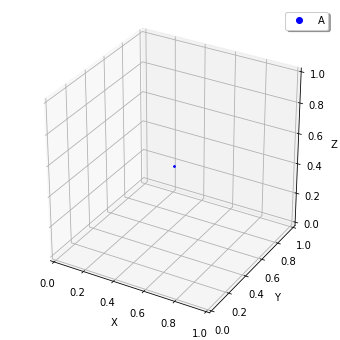

In [6]:
viz.plot_world(w, interactive=False)
# viz.plot_world(w)

また、 `FixedIntervalTrajectoryObserver`を使って、分子拡散プロセスの軌道を追跡することができます。


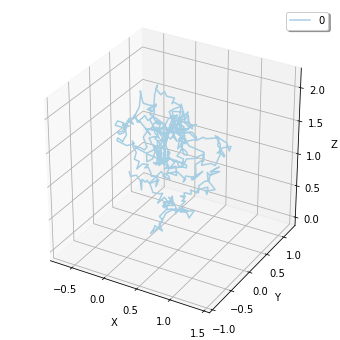

In [7]:
sim = spatiocyte.Simulator(w)
obs = FixedIntervalTrajectoryObserver(0.002, [pid])
sim.run(1, obs)
viz.plot_trajectory(obs, interactive=False)
# viz.plot_trajectory(obs)

ここでは `viz.plot_trajectory`メソッドで軌跡を可視化しましたが、`data`メソッドで`Real3`のリストとして結果を取得することも可能です。


In [8]:
print(len(obs.data()))  # => 1
print(len(obs.data()[0]))  # => 501

1
501


`data`メソッドはネストされたリストを返します。
最初のインデックスは、粒子のインデックスを意味します。
2番目のインデックスは、 `Real3`のインデックスを意味します。
この場合、我々は1つだけパーティクルを投げたので、最初の結果は「1」であり、次の「501」は、1つのパーティクル（初期座標と1 / 0.002 = 500タイムポイントの座標）の時系列座標を意味します。


`list_particles_exact`メソッドと` Species`メソッドを使って、一括してパーティクルを取得することもできます。


In [9]:
w.add_molecules(Species('A'), 5)

particles = w.list_particles_exact(Species('A'))
for pid, p in particles:
    print(p.species().serial(), tuple(p.position()))

A (0.1061445555206044, 0.42723919920032305, 0.26)
A (0.27760883751542687, 0.9266471820493494, 0.395)
A (0.4409081537009721, 0.8054036255195279, 0.34500000000000003)
A (0.016329931618554522, 0.09526279441628825, 0.405)
A (0.8328265125462806, 0.4416729559300637, 0.655)
A (0.4082482904638631, 0.7361215932167728, 0.745)


`list_particles_exact`メソッドは覚えておいてください。
このメソッドは、他の`World`に対しても`add_molecules`メソッド同様に使えます。

別の注意点として、Spatiocyteで一つの分子を調査する適切な方法は `list_voxels_exact`であり、座標はボクセルのインデックス（`Real3`ではありません）で記述されます。


## 10.3 拡散係数と二次反応

私たちが扱っているモデルには二次反応が含まれています。
この二次反応とSpatiocyteの拡散係数との関係を見てみましょう。


In [10]:
with species_attributes():
    A | B | C | {'D': 1}

with reaction_rules():
    A + B > C | 1.0

m = get_model()

In [11]:
w = spatiocyte.World(Real3(2, 1, 1), 0.005)
w.bind_to(m)
w.add_molecules(Species('A'), 120)
w.add_molecules(Species('B'), 120)

obs = FixedIntervalNumberObserver(0.005, ('A', 'B', 'C'))
sim = spatiocyte.Simulator(w)
sim.run(1.0, obs)

In [12]:
odew = ode.ODEWorld(Real3(2, 1, 1))
# odew.bind_to(m)
odew.add_molecules(Species('A'), 120)
odew.add_molecules(Species('B'), 120)

odeobs = FixedIntervalNumberObserver(0.005, ('A', 'B', 'C'))
odesim = ode.ODESimulator(odew, m)
odesim.run(1.0, odeobs)

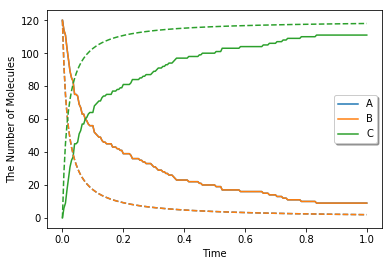

In [13]:
viz.plot_number_observer(obs, "-", odeobs, "--")

以前よりもより速い速度定数を使用しましたが、結果は同じです。
しかし、ODEシミュレーションと比べると、それらの違いを見つけることができます（実線は`spatiocyte`、破線は`ode`）。
Spatiocyteが間違っているのでしょうか？ （いいえ，間違っているわけではありません。）
実はSpatiocyteの反応速度は速くなりません。一方ODEの反応速度は無限に速くなり得ます。

これは、ODEソルバーと一分子シミュレーション法の反応速度定数の定義の違いが原因です。
前者は"macroscopic"なまたは"effective"な反応速度定数と呼ばれ、後者は"microscopic"なまたは"intrinsic"な反応速度定数と呼ばれます。


"macroscopic"な速度は分子が混ざっている状態における反応速度を表し、一方、"microscopic"な速度は分子衝突における反応性を表します。
そのため "microscopic"な視点では、最初に分子が反応するためにまず必要なのは衝突です。
しかし、Spatiocyteでは、この"microscopic"な速度を速くすると、実際の反応速度を衝突速度より速くすることはできません。
これは"拡散律速"条件と呼ばれます。
これは、偏って配置された分子が反応するのに時間を要することに似ています。


この"macroscopic"な速度定数 $k_\mathrm{on}$ と3次元空間における"microscopic"な速度定数 $k_a$ との間には下記の関係があることが知られている。　

$\frac{1}{k_\mathrm{on}}=\frac{1}{k_a}+\frac{1}{4\pi RD_\mathrm{tot}},$

ここで $R$ は衝突における2分子の半径の合計に、$D_\mathrm{tot}$ は拡散係数の合計になります。

上記の Jupyter Notebook のセルの場合, $k_D=4\pi RD_\mathrm{tot}$ はおおよそ 0.25 で "microscopic" な速度定数は 1.0 になります。
そのため "macroscopic" な速度定数は約 0.2 になります。

(しかし、Spatiocyteの設定を指定しない限り、二次反応速度は $3\sqrt{2} RD$ より遅くなければならず、解離定数 $k_D$ も $3\sqrt{2} RD$ となります。)

一分子シミュレーション法は、よく混ざっている系(すなわち拡散係数が無限大)が想定されたODEやGillespie法とは違って、分子の"拡散"と"反応"を正確に分離することができます。

しかし、"microscopic"な速度定数 $k_D$ が十分に小さい場合、"macroscopic"な速度定数は"microscopic"な速度定数とほとんど同じになります(これは"reaction rate-limited"と呼ばれています)。


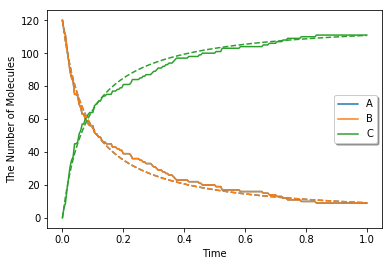

In [14]:
import numpy

kD = 4 * numpy.pi * (0.005 * 2) * (1 * 2)
ka = 1.0
kf = ka * kD / (ka + kD)

with reaction_rules():
    A + B > C | kf

odeobs = run_simulation(1, y0={'A': 120, 'B': 120}, volume=2, return_type='observer')

show(obs, "-", odeobs, "--")

## 10.4. Spatiocyte における "構造(Structure)"

次に、細胞膜のような構造(Structure)を作り出す方法について説明します。

E-Cell4全体としてのStructure機能はまだ開発中ですが、(E-Cell4が持つシミュレータの一つである)SpatiocyteにおいてはStructureがある程度サポートできています。

その一例として、球のStructureを見てみましょう。

球の内部の分子の拡散を(その内側に)制限するためには、まずその球を作成します。

In [15]:
with species_attributes():
    A | {'D': 1, 'location': 'C', 'dimension': 3}
    C | {'dimension': 3}

m = get_model()

In [16]:
w = spatiocyte.World(ones(), 0.005)
w.bind_to(m)
sph = Sphere(0.5 * ones(), 0.45)
print(w.add_structure(Species('C'), sph))  # will print 539805

539805


ここで `World` の状態を可視化してみましょう。

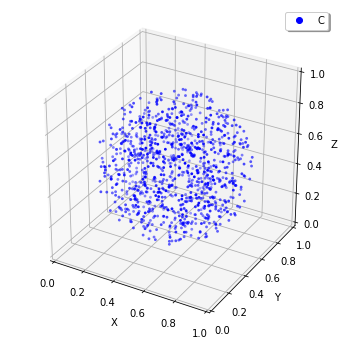

In [17]:
viz.plot_world(w, interactive=False)
# viz.plot_world(w)

`Sphere` クラスの第1引数は球の中心であり、第2引数は半径です。
次に、 `C` という名前の `Species` を作成して球の内部に追加しました。

SpatiocyteのStructureは、空間を `Voxel` で満たすことによって記述されます。

上記の例では、球体の `Voxel` は `C` という名前の `Species` で占められています。

上記のように `viz.plot_world` を使ってそれらの分布を見ることができます。
(しかし、Speciesの数はそのすべてを可視化するには大きすぎます。 そのため、私たちはその一部だけをプロットしています。しかし実際には球体は完全に`Species`で占められています。)

次に、この球の内部を移動する`Species`を作成します。

そのために`Species`に`location`の属性を与えます。 その後は、`add_molecules`関数を使って`World`に分子を投げ込むだけです。


In [18]:
w.add_molecules(Species('A'), 120)

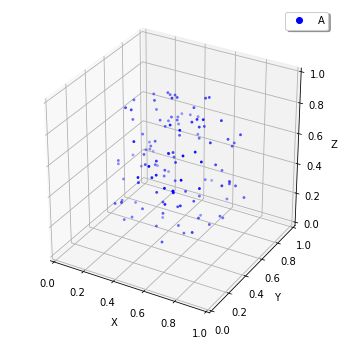

In [19]:
viz.plot_world(w, species_list=('A',), interactive=False)  # visualize A-molecules only
# viz.plot_world(w, species_list=('A',))  # visualize A-molecules only

ここで、私達は `Species` `A` の軌道を `Species` `C`のStructureに制限したので、`add_molecules`はそのように働きます。 注意として、 `add_molecules`の前にStructureを作成する必要があることがあります。

そして`FixedIntervalTrajectoryObserver`を使って拡散領域の制限をチェックすることができます。


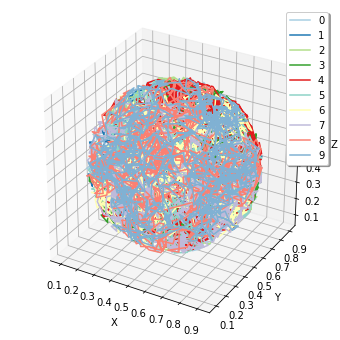

In [20]:
pid_list = [pid for pid, p in w.list_particles(Species('A'))[: 10]]
obs = FixedIntervalTrajectoryObserver(1e-3, pid_list)
sim = spatiocyte.Simulator(w)
sim.run(1, obs)
viz.plot_trajectory(obs, interactive=False)
# viz.plot_trajectory(obs)

`pid_list`は` A`分子の `ParticleID`の最初の10個のリストです。
軌道はこの10`Species`によって着色されています。
確かに、軌道は球体内に制限されています。


## 10.5 構造(Structure)と反応

最後に、Structure間の分子のトランスロケーションについて説明します。

`location` 属性のない `Species` は、どのStructureのメンバーでもありません。
上記の例では、Species `A` で `location` 属性を記述しないと、球の外側に `A` が置かれます。

次に、平面構造を作成しましょう。
面を作成するには、3つの `Real3` を使用する必要があります。
それは原点(`origin`)と，軸ベクトルの2点(`unit0`、` unit1`)です。
プログラムでは `ps = PlanarSurface(origin、unit0、unit1)` となります。

面 `ps` に `Species` `A` があり、通常の `Species` `B` がある状態を想像してみてください。


In [21]:
with species_attributes():
    A | {'D': '0.1', 'location': 'M', 'dimension': 2}
    B | {'D': 1}
    M | {'dimension': 2}

m  = get_model()

w = spatiocyte.World(ones())
w.bind_to(m)

origin = Real3(0, 0, 0.5)
w.add_structure(
    Species('M'), PlanarSurface(origin, unitx(), unity()))  # Create a structure first

w.add_molecules(Species('B'), 480)  # Throw-in B-molecules

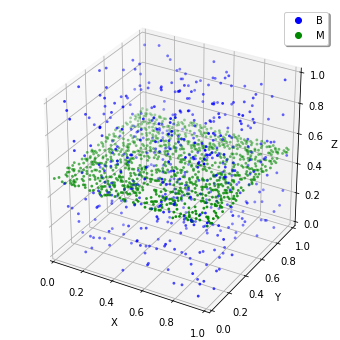

In [22]:
viz.plot_world(w, species_list=('B', 'M'), interactive=False)
# viz.plot_world(w, species_list=('B', 'M'))

見るのは難しいかもしれませんが、実際には`Species` `B` は面上でないところにしか置かれていません。

それではどうすれば、この`Species` `B` を面 `M` に吸収させ、`Species` `A` を合成することができるでしょうか?


In [23]:
with species_attributes():
    A | {'D': '0.1', 'location': 'M', 'dimension': 2}
    B | {'D': 1}
    M | {'dimension': 2}

with reaction_rules():
    B + M == A | (1.0, 1.5)

m = get_model()

これは、 `Species` `B` が Structure `M` に衝突したとき、 `A`になることを意味します。

一方、`Species` `A` はStructureから解離し、逆反応の方向としては `M` そして `B` になります。

これでStructureを用いたモデルをシミュレーションできるようになりました。


In [24]:
w.bind_to(m)

sim = spatiocyte.Simulator(w)
obs = NumberObserver(('A', 'B'))
sim.run(2, obs)

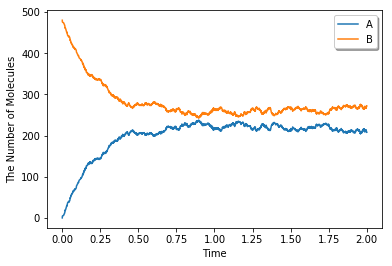

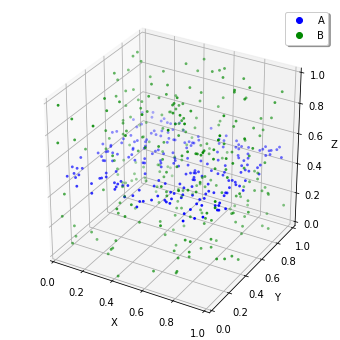

In [25]:
viz.plot_number_observer(obs)
viz.plot_world(w, species_list=('A', 'B'), interactive=False)
# viz.plot_world(w, species_list=('A', 'B'))

Structureからの解離反応では、そのStructureを書くことが省略できます。
したがって、`A > B` は、上の `A > B + M` と同じ意味になります。

しかし, 結合反応においては これと同様の省略はできません。

周りに `M` がない状態で `B` から `A` を作ることは不可能だからです。
対照的に、`Species` `A` は、球 `M` 上のどこでも `Species` `B` を生成することができます。

一次反応は、`Structure`の存るところまたは無いところのいずれかで起こります。

しかし、結合反応の場合には、二次反応は一次反応に変わり、左辺の `M` を無視すれば速度定数の意味も変わります。
